# Mathmatical manipulation with Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from functools import partial

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = ['../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

#the operation to be used for math operations during training.
math_operation = partial(np.square)

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


In [4]:
test_dfs[test_index].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 10:30,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6
1,4/11/2018 10:45,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6
2,4/11/2018 11:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7
3,4/11/2018 11:15,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7
4,4/11/2018 11:30,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7


In [5]:
train_dfs[train_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,18.488235,1933.564575,-116.806951,8.633415,58.129348,87.056980,8.179008,0.979511
std,6.134464,151.800551,8.973830,0.147231,54.622278,13.793755,1.278416,0.731423
min,5.630000,3.000000,-153.700000,7.930000,0.660000,62.800000,5.170000,0.000000
25%,12.700000,1848.000000,-120.800000,8.530000,29.850000,80.000000,7.260000,0.500000
50%,20.320000,1939.000000,-115.700000,8.650000,42.140000,83.200000,8.080000,0.900000
75%,23.630000,2070.000000,-112.100000,8.700000,65.795000,88.900000,9.250000,1.200000
max,28.570000,2164.000000,-76.500000,9.230000,636.700000,209.700000,16.170000,16.100000


In [6]:
test_dfs[test_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000
mean,19.131184,1990.294607,-196.624329,8.922357,63.929067,90.057202,8.309566,1.459773
std,5.045367,230.743946,27.769024,0.357733,70.885989,17.627283,1.486747,1.311960
min,0.000000,0.000000,-284.000000,0.000000,-0.880000,0.000000,0.000000,-0.400000
25%,15.480000,1869.000000,-216.950000,8.730000,33.750000,79.100000,7.280000,0.600000
50%,20.190000,1958.000000,-192.000000,8.920000,48.380000,85.300000,8.010000,1.000000
75%,23.070000,2149.000000,-179.500000,9.100000,68.275000,95.300000,9.240000,1.700000
max,28.600000,2417.000000,0.000000,10.100000,1248.920000,245.500000,19.590000,21.100000


## Use Datetime Index

In [7]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [8]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [9]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


In [10]:
# Fill all missing values with the mean
for df in test_dfs + train_dfs:
    for column in df.columns:
        number_null = np.sum(df[column].isnull())
        column_length = len(df[column])
        print('{} percent null: {:.1f}%'.format(
            column, (number_null / column_length) * 100))
        if number_null > 0:
            print("Filling {} with mean: {}\n".format(column, df[column].mean()))
            df[column] = df[column].fillna(df[column].mean()) 

Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 3.2%
Filling Turbidity (NTU) with mean: 64.9625066543

## BGA RFU Levels

In [11]:
presegmented_plot = pd.DataFrame(
    {'BGA RFU': train_dfs[train_index][target_column], 
     'Bloom Threshold': np.full(train_dfs[train_index].count()[0], RFU_THRESHOLD)})

In [12]:
# Segment each data frame
for i in range(0, len(train_dfs)):
    print("Windowizing 2017 data set:", i)
    train_dfs[i] = hf.data_window_reduction(
        train_dfs[i], 'datetime', target_column)
    print("Windowizing 2018 data set:", i)
    test_dfs[i] = hf.data_window_reduction(
        test_dfs[i], 'datetime', target_column)
    print()

Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



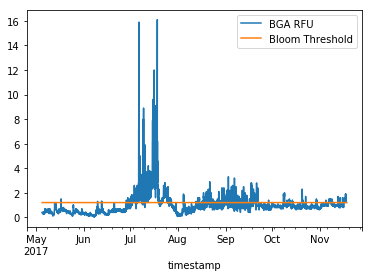

In [13]:
presegmented_plot.plot.line()

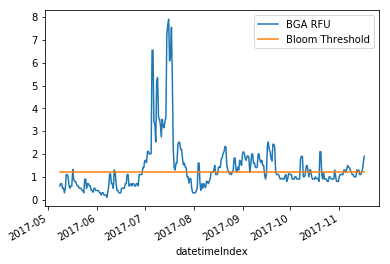

In [14]:
pd.DataFrame({'BGA RFU': train_dfs[train_index][target_column], 
            'Bloom Threshold': np.full(
                train_dfs[train_index].count()[0], RFU_THRESHOLD)}).plot.line()

## Logistic Regression Model

In [15]:

# combine the sets
train = train_dfs[0].append(train_dfs[1])
test = test_dfs[0].append(test_dfs[1])
# add the target
lrf.add_target_column([train, test], 
                      threshold=RFU_THRESHOLD)

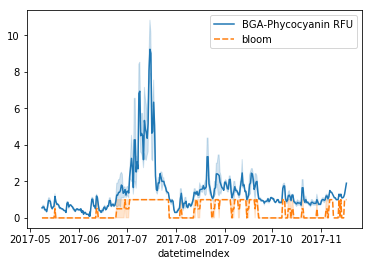

In [16]:
sns.lineplot(data=train[[target_column, 'bloom']], hue='bloom')

In [17]:
# Test Squared functionality
train.head(5)


,BGA-Phycocyanin RFU,ODO (mg/L),ODOSat%,Sp Cond (uS/cm),Temp C,Turbidity (NTU),datetime,pH,pH (mV),bloom
datetimeIndex,,,,,,,,,,
2017-05-08 07:48:00,0.6,9.464,95.66,1939.0,17.308,97.160,2017-05-08 07:48:00,8.39,-99.20,0
2017-05-08 21:48:00,0.7,9.464,95.66,1953.0,17.532,97.276,2017-05-08 21:48:00,8.39,-99.20,0
2017-05-09 11:48:00,0.7,8.852,90.70,1953.0,17.914,97.276,2017-05-09 11:48:00,8.38,-99.20,0
2017-05-10 01:48:00,0.5,8.534,88.42,1953.0,18.330,100.720,2017-05-10 01:48:00,8.38,-99.20,0
2017-05-10 15:48:00,0.5,8.304,87.02,1953.0,18.820,97.324,2017-05-10 15:48:00,8.38,-99.58,0


In [18]:
lrf.apply_math_operation(train[x_columns], math_operation, "_squared").head(5)

C:\git\senior_design\pannts-ml\notebooks\models\scripts\logistic_regression_functions.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  result[col + name_addition] = op(dataframe[col])


,Temp C_squared,Sp Cond (uS/cm)_squared,pH (mV)_squared,pH_squared,Turbidity (NTU)_squared,ODOSat%_squared,ODO (mg/L)_squared
datetimeIndex,,,,,,,
2017-05-08 07:48:00,299.566864,3759721.0,9840.6400,70.3921,9440.065600,9150.8356,89.567296
2017-05-08 21:48:00,307.371024,3814209.0,9840.6400,70.3921,9462.620176,9150.8356,89.567296
2017-05-09 11:48:00,320.911396,3814209.0,9840.6400,70.2244,9462.620176,8226.4900,78.357904
2017-05-10 01:48:00,335.988900,3814209.0,9840.6400,70.2244,10144.518400,7818.0964,72.829156
2017-05-10 15:48:00,354.192400,3814209.0,9916.1764,70.2244,9471.960976,7572.4804,68.956416


In [19]:
# Add the squared features to the training and test sets.
squared = lrf.apply_math_operation(test[x_columns], math_operation, "_squared")
print(test.shape)
test[squared.columns] = squared
print(test.shape)

squared = lrf.apply_math_operation(train[x_columns], math_operation, "_squared")
print(train.shape)
train[squared.columns] = squared
print(train.shape)

# Add the new columns to x_columns
x_columns = list(set(x_columns + list(squared.columns)))
print(x_columns)
train.head(5)

C:\git\senior_design\pannts-ml\notebooks\models\scripts\logistic_regression_functions.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  result[col + name_addition] = op(dataframe[col])


(682, 10)
(682, 17)
(643, 10)
(643, 17)
['Turbidity (NTU)_squared', 'ODOSat%', 'pH (mV)', 'ODOSat%_squared', 'Temp C', 'Sp Cond (uS/cm)_squared', 'pH_squared', 'Turbidity (NTU)', 'pH (mV)_squared', 'ODO (mg/L)_squared', 'Sp Cond (uS/cm)', 'pH', 'ODO (mg/L)', 'Temp C_squared']


,BGA-Phycocyanin RFU,ODO (mg/L),ODOSat%,Sp Cond (uS/cm),Temp C,Turbidity (NTU),datetime,pH,pH (mV),bloom,Temp C_squared,Sp Cond (uS/cm)_squared,pH (mV)_squared,pH_squared,Turbidity (NTU)_squared,ODOSat%_squared,ODO (mg/L)_squared
datetimeIndex,,,,,,,,,,,,,,,,,
2017-05-08 07:48:00,0.6,9.464,95.66,1939.0,17.308,97.160,2017-05-08 07:48:00,8.39,-99.20,0,299.566864,3759721.0,9840.6400,70.3921,9440.065600,9150.8356,89.567296
2017-05-08 21:48:00,0.7,9.464,95.66,1953.0,17.532,97.276,2017-05-08 21:48:00,8.39,-99.20,0,307.371024,3814209.0,9840.6400,70.3921,9462.620176,9150.8356,89.567296
2017-05-09 11:48:00,0.7,8.852,90.70,1953.0,17.914,97.276,2017-05-09 11:48:00,8.38,-99.20,0,320.911396,3814209.0,9840.6400,70.2244,9462.620176,8226.4900,78.357904
2017-05-10 01:48:00,0.5,8.534,88.42,1953.0,18.330,100.720,2017-05-10 01:48:00,8.38,-99.20,0,335.988900,3814209.0,9840.6400,70.2244,10144.518400,7818.0964,72.829156
2017-05-10 15:48:00,0.5,8.304,87.02,1953.0,18.820,97.324,2017-05-10 15:48:00,8.38,-99.58,0,354.192400,3814209.0,9916.1764,70.2244,9471.960976,7572.4804,68.956416


In [20]:
# The null model's performance
max_iter = 25000
loss = "log"
print(x_columns)
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train, test, x_columns, 'bloom', True)
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", train.columns)

['Turbidity (NTU)_squared', 'ODOSat%', 'pH (mV)', 'ODOSat%_squared', 'Temp C', 'Sp Cond (uS/cm)_squared', 'pH_squared', 'Turbidity (NTU)', 'pH (mV)_squared', 'ODO (mg/L)_squared', 'Sp Cond (uS/cm)', 'pH', 'ODO (mg/L)', 'Temp C_squared']
Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]
columns: Index(['BGA-Phycocyanin RFU', 'ODO (mg/L)', 'ODOSat%', 'Sp Cond (uS/cm)',
       'Temp C', 'Turbidity (NTU)', 'datetime', 'pH', 'pH (mV)', 'bloom',
       'Temp C_squared', 'Sp Cond (uS/cm)_squared', 'pH (mV)_squared',
       'pH_squared', 'Turbidity (NTU)_squared', 'ODOSat%_squared',
       'ODO (mg/L)_squared'],
      dtype='object')


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                            test,
                                            x_columns,
                                            'bloom')

Training model with: Turbidity (NTU)_squared


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]

Training model with: ODOSat%
Accuracy 0.6950146627565983
Recall: 0.5731414868105515
Precision 0.8884758364312267
Confusion Matrix:
 [[235  30]
 [178 239]]

Training model with: pH (mV)
Accuracy 0.6085043988269795
Recall: 0.988009592326139
Precision 0.6112759643916914
Confusion Matrix:
 [[  3 262]
 [  5 412]]

Training model with: ODOSat%_squared
Accuracy 0.6906158357771262
Recall: 0.5419664268585132
Precision 0.9186991869918699
Confusion Matrix:
 [[245  20]
 [191 226]]

Training model with: Temp C
Accuracy 0.6143695014662757
Recall: 0.42685851318944845
Precision 0.8811881188118812
Confusion Matrix:
 [[241  24]
 [239 178]]

Training model with: Sp Cond (uS/cm)_squared


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]

Training model with: pH_squared
Accuracy 0.7243401759530792
Recall: 0.8129496402877698
Precision 0.755011135857461
Confusion Matrix:
 [[155 110]
 [ 78 339]]

Training model with: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]

Training model with: pH (mV)_squared
Accuracy 0.6085043988269795
Recall: 0.988009592326139
Precision 0.6112759643916914
Confusion Matrix:
 [[  3 262]
 [  5 412]]

Training model with: ODO (mg/L)_squared
Accuracy 0.6642228739002932
Recall: 0.5323741007194245
Precision 0.8671875
Confusion Matrix:
 [[231  34]
 [195 222]]

Training model with: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]

Training model with: pH
Accuracy 0.7243401759530792
Recall: 0.8129496402877698
Precision 0.755011135857461
Confusion Matrix:
 [[155 110]
 [ 78 339]]

Training model with: ODO (mg/L)
Accuracy 0.6642228739002932
Recall: 0.5323741007194245
Precision 0.8671875
Confusion Matrix:
 [[231  34]
 [195 222]]

Training model with: Temp C_squared
Accuracy 0.6011730205278593
Recall: 0.4028776978417266
Precision 0.8795811518324608
Confusion Matrix:
 [[242  23]
 [249 168]]

pH_squared metric value: 0.7243401759530792
pH metric value: 0.7243401759530792
ODOSat% metric value: 0.6950146627565983
ODOSat%_squared metric value: 0.6906158357771262
ODO (mg/L)_squared metric value: 0.6642228739002932
ODO (mg/L) metric value: 0.6642228739002932
Temp C metric value: 0.6143695014662757
pH (mV) metric value: 0.6085043988269795
pH (mV)_squared metric value: 0.6085043988269795
Temp C_squared metric value: 0.6011730205278

In [22]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train, test, x_columns, 'bloom', sorted_columns)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['pH_squared', 'pH', 'ODOSat%', 'ODOSat%_squared', 'ODO (mg/L)_squared', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'pH (mV)_squared', 'Temp C_squared', 'Turbidity (NTU)_squared', 'Sp Cond (uS/cm)_squared', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH_squared', 'pH', 'ODOSat%', 'ODOSat%_squared', 'ODO (mg/L)_squared', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'pH (mV)_squared', 'Temp C_squared', 'Turbidity (NTU)_squared', 'Sp Cond (uS/cm)_squared', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['pH_squared']
Test model accuracy: 0.7243401759530792
Test model recall: 0.8129496402877698
Test model precision: 0.755011135857461

Updating greedy model

Training model with: ['pH_squared', 'pH']
Test model accuracy: 0.7243401759530792
Test model recall: 0.8129496402877698
Test model precision: 0.755011135857461

Training model with: ['pH_squared', 'ODOSat%']
Test model accuracy: 0.7595307917888563
Test model recall: 0.7482014388489209
Test

Model AUC: 0.8595


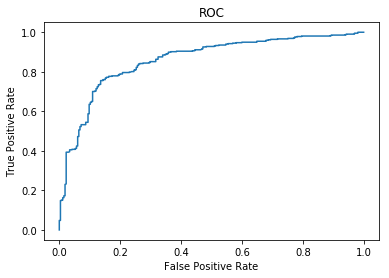

In [23]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test[['bloom']].values, predictions)

## Random Forest Model

In [24]:
# All Inputs
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train, test, x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.7155425219941349
Recall: 0.8848920863309353
Precision 0.7165048543689321
Confusion Matrix:
 [[119 146]
 [ 48 369]]


Model AUC: 0.7922


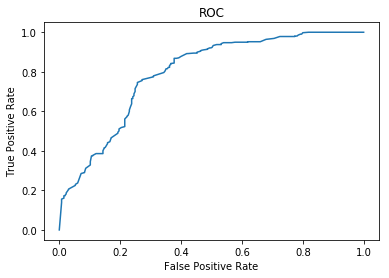

In [26]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test[['bloom']].values, predictions)